In [1]:
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import compute_ior_gradient, generate_initial_wavefront, simulate_wavefront_propagation, remove_under_floor
from common.plot import Plotter
from data.octree import Octree
from data.mlp import MLP
from data.np_grid import *
import taichi as ti
from scipy import ndimage

# debug=True to check boundary access
ti.init(arch=ti.gpu)

%load_ext autoreload
%autoreload 2

# Commented because the compatibility of this extension is not good
%matplotlib widget 

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda


In [7]:
from data.siren import *

raw_irradiance, _ = load_irrad_loc_dir(sampler_multiplier=3)   
irrad_data = VoxelFitting(raw_irradiance, 128)

torch.cuda.empty_cache()
dataloader = DataLoader(irrad_data, batch_size=1, pin_memory=True, num_workers=0)
img_siren = Siren(in_features=3, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

# total_steps = 100 # Since the whole image is our dataset, this just means 500 gradient descent steps.
# steps_til_summary = 10

# optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

# model_input, ground_truth = next(iter(dataloader))
# model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

# for step in range(total_steps):
#     model_output, coords = img_siren(model_input)
#     loss = ((model_output - ground_truth)**2).mean()

#     if not step % steps_til_summary:
#         print("Step %d, Total loss %0.6f" % (step, loss))

#     optim.zero_grad()
#     loss.backward()
#     optim.step()

[ Loaded ] irradiance and local direction from c:\Users\yaozi\Desktop\Voxel-Render\data\saves\NP(irrad,loc_dir)(3-samplers).npz
torch.Size([128, 128, 128])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([1, 256, 256])
Step 0, Total loss 0.244725


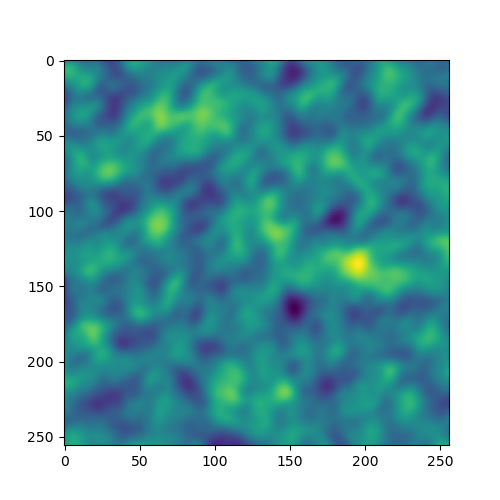

Step 100, Total loss 0.016282


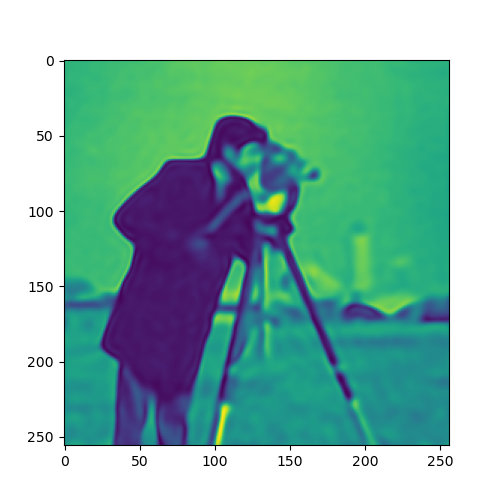

Step 200, Total loss 0.008697


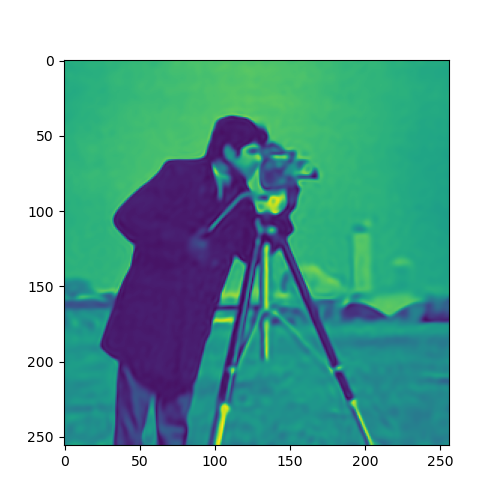

Step 300, Total loss 0.004837


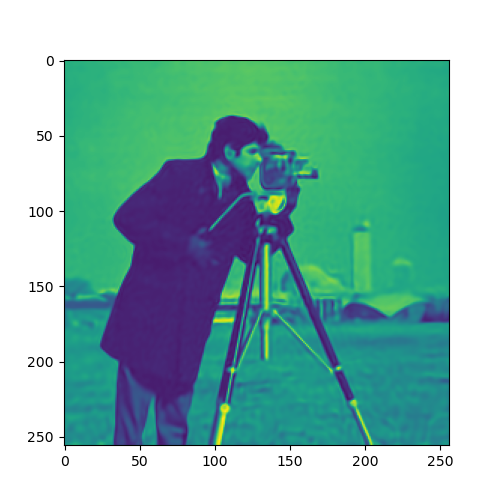

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from data.siren import *


cameraman_img = Image.open("cameraman.jpg").convert("L")

cameraman = ImageFitting(cameraman_img, 256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

total_steps = 400 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        plt.figure(figsize=(5,5))
        plt.imshow(model_output.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

## 1. Load voxel model

In [ ]:
NUM_XYZ = (128, 128, 128)
scene, floor_height = setup_voxel_scene(*NUM_XYZ)

## 2. Path tracing render

In [ ]:
scene.finish()

## 3. Perform light simulation

In [ ]:
assert scene.ior.shape == NUM_XYZ, "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45
initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, *NUM_XYZ)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter = Plotter(sampler_multiplier, floor_height, scene.ior)
# plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
# plotter.plot_gradient(scene.gradient, threshold=0.01, alpha=0.01)
load = False
if load and irrad_loc_dir_save_exists(sampler_multiplier):
    raw_irradiance, scene.local_diretion = load_irrad_loc_dir(sampler_multiplier)    
else:
    step_size = 0.3 * (NUM_XYZ[1] / 100)
    num_steps = int(1.0 * (NUM_XYZ[1]  / step_size))
    num_show_images = 4
    raw_irradiance, scene.local_diretion = simulate_wavefront_propagation(scene.ior, scene.gradient, scene.attenuation,
                                                    initial_wavefront_pos, initial_wavefront_dir,
                                                    plotter, num_steps, step_size, num_show_images)
    save_irrad_loc_dir(raw_irradiance, scene.local_diretion, sampler_multiplier)

raw_irradiance = remove_under_floor(raw_irradiance, floor_height=floor_height)
scene.irradiance = ndimage.gaussian_filter(raw_irradiance, sigma=0.8) 
# plotter.plot_irradiance_slices(raw_irradiance, threshold=3, num_slices=4, z_start=30, z_end=100)
plotter.plot_irradiance_slices(scene.irradiance, threshold=3, num_slices=4, z_start=30, z_end=100)

## 4. Store irradiance in Neural network irradiance （MLP）

In [ ]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier=sampler_multiplier, num_epoches=30)

In [ ]:
# Visualize the predicted irradiance field
predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

## 5. SIREN

## 5. Store irradiance in octree

In [ ]:
octree = Octree(threshold=int(0.6 * (sampler_multiplier**3)))
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

In [ ]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

## 6. Ray marching render